<a href="https://colab.research.google.com/github/AlbertoVentura8/AnalisisPredictivo/blob/main/MarchMad_Prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Permiso para exportar desde Drive
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Voy a cargar las librerías que vamos a usar a lo largo del EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [3]:
#Hacemos la carga del dataset. Dataset previamente subido a GoogleColab.
March_Madness_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1VRodxJqhnl2IK63lmumPhLwhRDe6Y2Gu')
March_Madness_df.head()

,Unnamed: 0,Season,Team Name,Conference,Adjusted Temo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,Avg Possession Length (Offense),Avg Possession Length (Defense),eFGPct,...,SFOR,SGOR,PGOR,CenterDR,PFDR,SFDR,SGDR,PGDR,Net Rating,Is_Champion
0,0,2015,Kentucky,Southeastern Conference (SEC),62.4,121.3,84.4,17.7,19.6,0.515116,...,20.03,5.69,6.08,27.92,30.08,18.01,13.00,10.99,36.9,No Llega
1,1,2021,Gonzaga,West Coast Conference (WCC),73.8,126.4,89.9,14.4,18.0,0.610178,...,6.54,22.61,11.41,23.99,18.56,13.28,24.63,19.49,36.5,No
2,2,2024,UConn,Big East Conference,64.6,127.5,91.1,18.6,17.5,0.569075,...,20.29,13.83,14.05,25.88,17.21,20.98,20.55,15.33,36.4,Si
3,3,2008,Kansas,Big 12 Conference,66.8,120.9,85.7,18.6,17.5,0.565912,...,22.11,5.59,5.77,26.38,28.48,18.37,13.90,12.87,35.2,Si
4,4,2019,Virginia,Atlantic Coast Conference (ACC),59.4,123.4,89.2,21.0,18.8,0.551800,...,14.67,8.82,8.61,23.45,26.61,18.51,17.84,13.59,34.2,Si


In [4]:
# Vamos a ver las variables
March_Madness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6767 entries, 0 to 6766
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       6767 non-null   int64  
 1   Season                           6767 non-null   int64  
 2   Team Name                        6767 non-null   object 
 3   Conference                       6767 non-null   object 
 4   Adjusted Temo                    6767 non-null   float64
 5   Adjusted Offensive Efficiency    6767 non-null   float64
 6   Adjusted Defensive Efficiency    6767 non-null   float64
 7   Avg Possession Length (Offense)  6767 non-null   float64
 8   Avg Possession Length (Defense)  6767 non-null   float64
 9   eFGPct                           6767 non-null   float64
 10  TOPct                            6767 non-null   float64
 11  ORPct                            6767 non-null   float64
 12  OffFT               

In [5]:
#Eliminar columna Unnamed0
del March_Madness_df['Unnamed: 0']
March_Madness_df.head()

,Season,Team Name,Conference,Adjusted Temo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,Avg Possession Length (Offense),Avg Possession Length (Defense),eFGPct,TOPct,...,SFOR,SGOR,PGOR,CenterDR,PFDR,SFDR,SGDR,PGDR,Net Rating,Is_Champion
0,2015,Kentucky,Southeastern Conference (SEC),62.4,121.3,84.4,17.7,19.6,0.515116,0.162529,...,20.03,5.69,6.08,27.92,30.08,18.01,13.00,10.99,36.9,No Llega
1,2021,Gonzaga,West Coast Conference (WCC),73.8,126.4,89.9,14.4,18.0,0.610178,0.161279,...,6.54,22.61,11.41,23.99,18.56,13.28,24.63,19.49,36.5,No
2,2024,UConn,Big East Conference,64.6,127.5,91.1,18.6,17.5,0.569075,0.144997,...,20.29,13.83,14.05,25.88,17.21,20.98,20.55,15.33,36.4,Si
3,2008,Kansas,Big 12 Conference,66.8,120.9,85.7,18.6,17.5,0.565912,0.191079,...,22.11,5.59,5.77,26.38,28.48,18.37,13.90,12.87,35.2,Si
4,2019,Virginia,Atlantic Coast Conference (ACC),59.4,123.4,89.2,21.0,18.8,0.551800,0.147067,...,14.67,8.82,8.61,23.45,26.61,18.51,17.84,13.59,34.2,Si


In [6]:
# Para poder usar la columna Is_Champion como variable objetivo y crear correlaciones, lo más fácil va a ser darle un valor a cada texto
# Convertir la columna 'Is_Champion' en valores numéricos, para poder ver correlaciones
March_Madness_df['Is_Champion_Num'] = March_Madness_df['Is_Champion'].map({
    'Si': 2,
    'No': 1,  # Usamos 1 para finalista si existiera
    'No Llega': 0
})
March_Madness_df.head()

,Season,Team Name,Conference,Adjusted Temo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,Avg Possession Length (Offense),Avg Possession Length (Defense),eFGPct,TOPct,...,SGOR,PGOR,CenterDR,PFDR,SFDR,SGDR,PGDR,Net Rating,Is_Champion,Is_Champion_Num
0,2015,Kentucky,Southeastern Conference (SEC),62.4,121.3,84.4,17.7,19.6,0.515116,0.162529,...,5.69,6.08,27.92,30.08,18.01,13.00,10.99,36.9,No Llega,0
1,2021,Gonzaga,West Coast Conference (WCC),73.8,126.4,89.9,14.4,18.0,0.610178,0.161279,...,22.61,11.41,23.99,18.56,13.28,24.63,19.49,36.5,No,1
2,2024,UConn,Big East Conference,64.6,127.5,91.1,18.6,17.5,0.569075,0.144997,...,13.83,14.05,25.88,17.21,20.98,20.55,15.33,36.4,Si,2
3,2008,Kansas,Big 12 Conference,66.8,120.9,85.7,18.6,17.5,0.565912,0.191079,...,5.59,5.77,26.38,28.48,18.37,13.90,12.87,35.2,Si,2
4,2019,Virginia,Atlantic Coast Conference (ACC),59.4,123.4,89.2,21.0,18.8,0.551800,0.147067,...,8.82,8.61,23.45,26.61,18.51,17.84,13.59,34.2,Si,2


In [7]:
columns = ['Net Rating', 'AdjEM', 'Adjusted Offensive Efficiency', 'Adjusted Defensive Efficiency', 'eFGPct', 'FG2Pct', 'FG3Pct', 'BlockPct', 'OppFG2Pct', 'OppFG3Pct', 'OppBlockPct', 'EffectiveHeight', 'PGOR', 'PGDR', 'SGOR', 'SGDR', 'SFOR', 'SFDR', 'PFOR', 'PFDR', 'CenterOR', 'CenterDR', 'Bench']

for col in columns:
    if col not in March_Madness_df.columns:
        print(f"Column {col} is missing.")

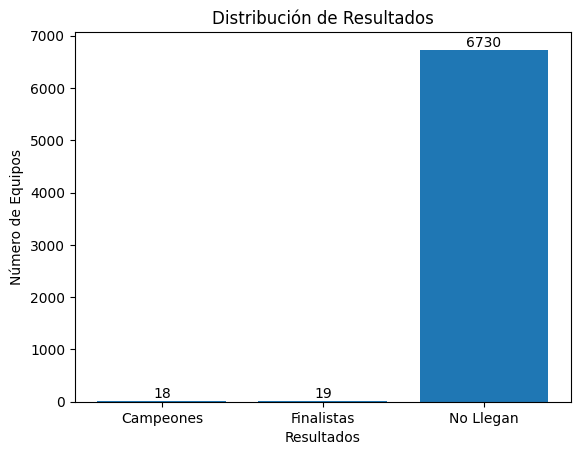

In [8]:
# Vamos a empezar con un gráfico donde se vea el % de campeones, de finalistas y de los que no llegan
# Calcular el número total de equipos
total_equipos = len(March_Madness_df)

# Calcular el número de equipos con cada resultado
campeones = (March_Madness_df['Is_Champion'] == 'Si').sum()
finalistas = (March_Madness_df['Is_Champion'] == 'No').sum()
no_llegan = (March_Madness_df['Is_Champion'] == 'No Llega').sum()

# Crear una lista con los resultados
resultados = [campeones, finalistas, no_llegan]

# Crear una lista de Categorias para las barras
Categorias = ['Campeones', 'Finalistas', 'No Llegan']

# Crear el gráfico de barras
plt.bar(Categorias, resultados)

#Mostrar el numero total de cada categoria en el grafico
for i, v in enumerate(resultados):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Configurar el título y las Categorias de los ejes
plt.title('Distribución de Resultados')
plt.xlabel('Resultados')
plt.ylabel('Número de Equipos')

# Mostrar el gráfico
plt.show()

In [9]:
# Vamos a ver la tabla con las variables predictivas y la variable objetivo

March_Madness_df[['Net Rating', 'AdjEM', 'Adjusted Offensive Efficiency', 'Adjusted Defensive Efficiency', 'eFGPct', 'FG2Pct', 'FG3Pct', 'BlockPct', 'OppFG2Pct',
                  'OppFG3Pct', 'OppBlockPct', 'EffectiveHeight', 'PGOR', 'PGDR', 'SGOR', 'SGDR', 'SFOR', 'SFDR', 'PFOR', 'PFDR', 'CenterOR', 'CenterDR', 'Bench', 'Is_Champion', 'Is_Champion_Num']].head()

# Vemos todas las columnas
pd.set_option('display.max_columns', None)



In [10]:
# Vamos a ver la tabla con las variables predictivas y la variable objetivo
# Vemos todas las columnas
pd.set_option('display.max_columns', None)
March_Madness_df[['Net Rating', 'AdjEM', 'Adjusted Offensive Efficiency', 'Adjusted Defensive Efficiency', 'eFGPct', 'FG2Pct', 'FG3Pct', 'BlockPct', 'OppFG2Pct',
                  'OppFG3Pct', 'OppBlockPct', 'EffectiveHeight', 'PGOR', 'PGDR', 'SGOR', 'SGDR', 'SFOR', 'SFDR', 'PFOR', 'PFDR', 'CenterOR', 'CenterDR', 'Bench', 'Is_Champion', 'Is_Champion_Num']].head(10)





,Net Rating,AdjEM,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,eFGPct,FG2Pct,FG3Pct,BlockPct,OppFG2Pct,OppFG3Pct,OppBlockPct,EffectiveHeight,PGOR,PGDR,SGOR,SGDR,SFOR,SFDR,PFOR,PFDR,CenterOR,CenterDR,Bench,Is_Champion,Is_Champion_Num
0,36.9,36.9118,121.3,84.4,0.515116,0.512117,0.348797,0.181633,0.391156,0.270898,0.059949,6.89,6.08,10.99,5.69,13.00,20.03,18.01,34.47,30.08,33.72,27.92,39.90,No Llega,0
1,36.5,36.4833,126.4,89.9,0.610178,0.638995,0.368098,0.069071,0.469685,0.327300,0.067784,0.65,11.41,19.49,22.61,24.63,6.54,13.28,19.89,18.56,39.47,23.99,24.27,No,1
2,36.4,36.4262,127.5,91.1,0.569075,0.591102,0.357518,0.141923,0.431655,0.312417,0.083333,1.53,14.05,15.33,13.83,20.55,20.29,20.98,18.66,17.21,33.13,25.88,28.14,Si,2
3,35.2,35.2083,120.9,85.7,0.565912,0.553672,0.396970,0.167407,0.411852,0.328162,0.063402,2.44,5.77,12.87,5.59,13.90,22.11,18.37,31.72,28.48,34.81,26.38,29.38,Si,2
4,34.2,34.2156,123.4,89.2,0.551800,0.525342,0.394834,0.129904,0.456844,0.288915,0.082864,1.18,8.61,13.59,8.82,17.84,14.67,18.51,30.03,26.61,37.86,23.45,22.86,Si,2
5,33.9,33.8670,125.0,91.1,0.565483,0.531842,0.412983,0.102873,0.487488,0.328597,0.105852,-0.56,5.21,11.65,7.14,16.34,15.00,14.23,39.18,27.69,33.47,30.09,28.57,Si,2
6,33.8,33.7197,129.0,95.2,0.547518,0.547925,0.364557,0.081725,0.446589,0.375465,0.063396,5.05,11.50,12.40,9.31,11.68,29.46,22.11,28.34,20.78,21.39,33.03,21.24,No,1
7,33.8,33.7563,127.8,94.0,0.595082,0.589704,0.400691,0.104990,0.489955,0.317016,0.081903,-0.43,4.45,13.94,9.99,17.28,19.54,19.99,27.17,19.16,38.82,29.62,25.88,Si,2
8,33.5,33.4687,125.0,91.5,0.563137,0.528520,0.422849,0.091261,0.468677,0.339678,0.085921,0.03,9.35,14.77,14.62,16.02,15.64,15.71,18.74,17.52,41.65,35.97,18.20,No Llega,0
9,33.3,33.2863,121.0,87.7,0.505270,0.469811,0.384910,0.098420,0.440462,0.282648,0.098113,4.88,7.41,9.76,6.17,13.36,21.55,19.76,23.77,23.46,41.10,33.66,23.41,Si,2


In [32]:
# Para el modelo predictivo, vamos a seleccionar las variables para la prediccion, son bastantes variables, pero nos va a ayudar a tener un análisis más preciso, y si fuese necesario, quitaremos inputs.
X = March_Madness_df[['Net Rating', 'AdjEM', 'Adjusted Offensive Efficiency', 'Adjusted Defensive Efficiency', 'eFGPct', 'FG2Pct', 'FG3Pct', 'BlockPct', 'OppFG2Pct', 'OppFG3Pct', 'OppBlockPct', 'EffectiveHeight', 'PGOR', 'PGDR', 'SGOR', 'SGDR', 'SFOR', 'SFDR', 'PFOR', 'PFDR', 'CenterOR', 'CenterDR', 'Bench']]
Y = March_Madness_df['Is_Champion_Num']
rs = 4477
test_size = 0.20
cv=5

# Separamos el modelo, y entrenamos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=rs)

#Escalado de los datos
Escalado = StandardScaler()
X_train_escal = Escalado.fit_transform(X_train)
X_test_escal = Escalado.transform(X_test)


In [33]:
#Parametros y modelos
parameters = {
    'solver':['lbfgs', 'sag', 'saga', 'newton-cg','liblinear'],
    'multi_class':['ovr','multinomial'],
}
model = LogisticRegression()
clf = GridSearchCV(model,
                   param_grid=parameters,
                   scoring='accuracy',
                   cv=cv)
clf.fit(X_train, Y_train)
print(clf.best_params_)

{'multi_class': 'ovr', 'solver': 'saga'}


In [31]:
# Vamos a empezar con el modelo predicitivo de regresion logistica
modelo_logistico = LogisticRegression(multi_class='ovr', solver='saga', class_weight='balanced', max_iter=10000)
modelo_logistico.fit(X_train_escal, Y_train)
Y_pred_logist = modelo_logistico.predict(X_test_escal)
accuracy_logist = accuracy_score(Y_test, Y_pred_logist)
print("Exactitud del modelo de regresión logística:", accuracy_logist)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_logist))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_logist))
print("\nAccuracy Score:", accuracy_score(Y_test, Y_pred_logist))
scores = cross_val_score(modelo_logistico, X, Y, cv=cv)
print(scores)

Exactitud del modelo de regresión logística: 0.9194977843426884
Confusion Matrix:
 [[   3    2    0]
 [  23 1240   84]
 [   0    0    2]]

Classification Report:
               precision    recall  f1-score   support

          No       0.12      0.60      0.19         5
    No Llega       1.00      0.92      0.96      1347
          Si       0.02      1.00      0.05         2

    accuracy                           0.92      1354
   macro avg       0.38      0.84      0.40      1354
weighted avg       0.99      0.92      0.95      1354


Accuracy Score: 0.9194977843426884


KeyboardInterrupt: 

In [35]:
# Crear el modelo Random Forest
RFor = RandomForestClassifier(n_estimators=300, random_state=rs)

# Ajustar el modelo a los datos de entrenamiento
RFor.fit(X_train_escal, Y_train)

# Realizar predicciones en los datos de prueba
Y_pred_rf = RFor.predict(X_test_escal)

# Evaluar el modelo
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_rf))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_rf))


Exactitud del modelo Random Forest: 0.9948301329394387
Confusion Matrix:
 [[1346    0    1]
 [   4    0    1]
 [   1    0    1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1347
           1       0.00      0.00      0.00         5
           2       0.33      0.50      0.40         2

    accuracy                           0.99      1354
   macro avg       0.44      0.50      0.47      1354
weighted avg       0.99      0.99      0.99      1354



In [39]:
# Vamos ahora con arboles de decision
decision_tree = DecisionTreeClassifier(random_state=rs)
decision_tree.fit(X_train_escal, Y_train)
Y_pred_dt = decision_tree.predict(X_test_escal)
accuracy = accuracy_score(Y_test, Y_pred_dt)
conf_matrix = confusion_matrix(Y_test, Y_pred_dt)
class_report = classification_report(Y_test, Y_pred_dt)

print("Exactitud del modelo de árboles de decisión:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
cv_scores_dt = cross_val_score(decision_tree, X, Y, cv=5)
print("Cross-Validation Scores:", cv_scores_dt)
print("Mean CV Score:", cv_scores_dt.mean())

Exactitud del modelo de árboles de decisión: 0.9918759231905465
Confusion Matrix:
 [[1342    3    2]
 [   3    1    1]
 [   1    1    0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1347
           1       0.20      0.20      0.20         5
           2       0.00      0.00      0.00         2

    accuracy                           0.99      1354
   macro avg       0.40      0.40      0.40      1354
weighted avg       0.99      0.99      0.99      1354

Cross-Validation Scores: [0.27917282 0.99483013 0.99482631 0.99260902 0.99482631]
Mean CV Score: 0.851252919001595


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)

In [ ]:
# Con los numevos parametros
modelo_logistico_opt = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced', max_iter=10000)
modelo_logistico_opt.fit(X_train_scaled, Y_resampled)
Y_pred_logist_opt = modelo_logistico_opt.predict(X_test_scaled)
print("Exactitud del modelo de regresión logística (optimizado):", accuracy_score(Y_test, Y_pred_logist_opt))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_logist_opt))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_logist_opt))

In [ ]:
#Entrenamiento del modelo
Clasificador  = RandomForestClassifier(n_estimators=100, random_state=rs,).fit(X_train, Y_train)

# Realizamos la prediccion y vemos la exactitud
Y_prediccion = Clasificador.predict(X_test)
accuracy = accuracy_score(Y_test, Y_prediccion)
print("Exactitud: ",accuracy_score(Y_test, Y_prediccion))

# Matriz de Confusión
matriz_confusion = confusion_matrix(Y_test, Y_prediccion)
print("Matriz de Confusión:")
print(matriz_confusion)


In [ ]:
# Crear el objeto SMOTE para aumentar significativamente las clases minoritarias
smote = SMOTE(sampling_strategy={0: 6730, 1: 100, 2: 50}, random_state=rs)  # Aumenta según la necesidad

# Ajustar y transformar los datos
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# Separar los datos resampleados en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=test_size, random_state=rs)

# Reentrenar el modelo
Clasificador = RandomForestClassifier(n_estimators=100, random_state=rs)
Clasificador.fit(X_train, Y_train)

# Realizar la predicción y evaluar el modelo
Y_prediccion = Clasificador.predict(X_test)
accuracy = accuracy_score(Y_test, Y_prediccion)
print(f"Exactitud: {accuracy}")

# Mostrar el reporte de clasificación
print(classification_report(Y_test, Y_prediccion, target_names=['No Llega', 'Finalista', 'Campeón']))

# Mostrar la matriz de confusión
matriz_confusion_ = confusion_matrix(Y_test, Y_prediccion)
print("Matriz de Confusión:")
print(matriz_confusion)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

# Generar predicciones
predictions_df = X_test.copy()
predictions_df['Prediction'] = Clasificador.predict(X_test)
predictions_df['Season'] = March_Madness_df.loc[X_test.index, 'Season']  # Añadir la columna 'Season' para mantener el contexto

# Verifica la distribución de las predicciones antes de filtrar
print(predictions_df['Prediction'].value_counts())

# Función para asegurar una única predicción por temporada
def ensure_unique_predictions(df):
    unique_predictions = []
    for season in df['Season'].unique():
        season_df = df[df['Season'] == season]
        print(f"Season: {season}, Size before filtering: {len(season_df)}")

        # Asegúrate de tener al menos un campeón y un subcampeón por temporada
        champion = season_df[season_df['Prediction'] == 2]
        if not champion.empty:
            unique_predictions.append(champion.head(1))
            continue

        finalist = season_df[season_df['Prediction'] == 1]
        if not finalist.empty:
            unique_predictions.append(finalist.head(1))
            continue

        # Si no hay campeón ni finalista, incluir más equipos que no llegan
        no_llega = season_df[season_df['Prediction'] == 0]
        if not no_llega.empty:
            unique_predictions.append(no_llega.head(min(len(no_llega), 20)))  # Ajusta el número si es necesario

    # Convertir la lista de DataFrames a un DataFrame único
    if unique_predictions:
        unique_predictions_df = pd.concat(unique_predictions, ignore_index=True)
        return unique_predictions_df
    return pd.DataFrame(columns=df.columns)  # Devolver un DataFrame vacío con las mismas columnas

# Aplicar el filtrado de predicciones
filtered_predictions_df = ensure_unique_predictions(predictions_df)

# Verifica el tamaño de los datos después de filtrar
print(f"Size after filtering: {len(filtered_predictions_df)}")

# Asegúrate de tener los verdaderos valores correspondientes para las predicciones filtradas
if not filtered_predictions_df.empty:
    # Alinear los índices para poder evaluar las predicciones
    filtered_index = filtered_predictions_df.index.intersection(X_test.index)
    Y_test_filtered = Y_test.loc[filtered_index]

    # Asegúrate de que las predicciones filtradas coincidan con los índices de Y_test
    filtered_predictions_df = filtered_predictions_df.loc[filtered_index]

    # Evaluar las predicciones filtradas (si es posible)
    if not Y_test_filtered.empty and len(Y_test_filtered) == len(filtered_predictions_df):
        accuracy_filtered = accuracy_score(Y_test_filtered, filtered_predictions_df['Prediction'])
        print(f"Exactitud después de filtrar: {accuracy_filtered}")

        # Mostrar la matriz de confusión para las predicciones filtradas
        filtered_conf_matrix = confusion_matrix(Y_test_filtered, filtered_predictions_df['Prediction'])
        print(filtered_conf_matrix)
    else:
        print("No hay suficientes valores verdaderos filtrados para evaluar la exactitud o los tamaños no coinciden.")
else:
    print("No hay suficientes predicciones filtradas para evaluar la exactitud.")
